# Herd immunity

Epidemics pass through populations by infecting the susceptible. In doing so they change the details of the population, leaving behind a trace of the epidemic's passing. In a real epidemic this includes the human cost of the  infections and deaths that occur. But it also includes other, more epidemiological, traces that include a change in the proportion of the population who remain susceptible to re-infection.

(sec:herd-immunity)=
## Immunity

By **immunity** we mean making an individual impervious to future infection by the disease. Immunity is conferred on an individual in three main ways.

```{margin}
Note that this isn't quite the same as saying that the immune individual can't be re-infected. They *are* re-infected, but defeat that infection far more efficiently than does a "normal" individual.
```

The simplest way to acquire immunity is to have had the disease before. Having been exposed to (and presumably defeated) the disease pathogen, the immune system stores information about the necessary response. If exposed to the pathogen again, the immune system is able to respond more quickly by having been sensitised to the pathogen. This means that the immune response starts more quickly after exposure, with less pathogen to contend with, and often means that the individual never becomes symptomatic.

```{margin}
Most diseases pathogens can't cross the placental barrier and so the mother doesn't infect the child.
```

For some diseases, an infection confers immunity on the pre-natal children of any mothers who are infected. This is a clever piece of evolution that means that children born into the midst of an epidemic are often immune to the disease if their mother was exposed.  

The widespread use of vaccines in the modern world for serious diseases is the final way to confer immunity. A vaccine essentially just pre-sensitises a person's immune system in the same way that a pre-occurring infection would do &ndash; but without the disadvantage of making the person sick in the first place.

(sec:herd-herd-immunity)=
## Herd immunity

If immunity is the inability of an individual to contract a disease, then **herd immunity** is the corresponding property for a population that can't contract an epidemic of the disease. More precisely, in a herd-immune population any outbreak of the disease will tend to die out quickly without infecting a large proportion of the population.

To understand herd immunity we need to return to the initial notions we had of how an epidemic persists in a population. We saw that {ref}`contact trees <sec:tracing-contact-trees>` capture the case reproduction number $R$ of an ongoing epidemic. We also {ref}`saw <sec:progress-r-care>` that if  $R \ge 1$ then the epidemic continues, as the next generation of cases is at least the same size as the previous one. If, however, $R$ falls and remains below 1, then the size of the next generation is smaller than the previous one, and if this trend continues then the disease will die out. 

Herd immunity occurs when $R \ll 1$ so that any epidemic never gets started. More importantly, it means that if an epidemic re-starts through the disease being re-introduced, it won't get re-started.

This doesn't mean that no-one ever gets infected in a herd-immune population: it's perfectly possible for people to come into contact with infected individuals from outside, and to become infected themselves if they aren't personally immune. But the disease doesn't spread from them into the rest of the population.

How does this come about? When discussing $R$ we {ref}`saw <sec:progress-R0>` that the case reproduction number is affected by three things: the duration of infectiousness, the probability of disease transmission per contact, and the rate of contacts between infected and susceptible individuals. The first two are properties of the disease, while the second is a property of the environment in which it finds itself. A herd-immune population is one in which the number of contacts between susceptible and infected individuals is too low to sustain an outbreak. Essentially herd immunity uses the topology of the contact network to reduce the value of $R$ below the critical threshold of 1.

## Epidemics on a residual network

We can model the effects of herd immunity by using the idea of a disease *repeatedly* being introduced to the *same* contact network. We let the disease run through the population, and then note that, for SIR infections, anyone who has been removed from the population cannot be re-infected, and indeed takes no further part in the disease dynamics. We are left with a **residual network** into which we re-introduce the same disease and see what happens.

The important thing to notice is that the second epidemic is caused by the re-introduction of the *same* disease, with the same infectiousness and period of infection. Will this instance of the disease spread? &ndash; only if the residual network is such that the disease can get hold in it. If the first epidemic caused enough nodes to be removed, then this may prevent a second epidemic in the same population (or, more accurately, in a large sub-set of the population who weren't infected the first time). 

This is another way to think about herd immunity. By removing nodes from the population it changes its topology so that disease propagation is no longer possible, or at least occurs at a radically smaller level. Any subsequent outbreaks are in some sense "squashed by the topology" even though the biology of the situation is unchanged. 

In [4]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.5)
from IPython.display import Image

In [2]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

For simplicity let's return to {doc}`ER networks <er>`. (The same arguments work perfectly well on power-law networks too.) We create a small network and run an SIR epidemic over it, choosing disease parameters that we know will create an epidemic.

In [3]:
N = 5000
kmean = 20

T = 5000

pInfected = 0.01
pInfect = 0.0002   # above the epidemic threshold
pRemove = 0.002

In [4]:
g = networkx.gnp_random_graph(N, (kmean + 0.0) / N)

In [5]:
param = dict()
param[epydemic.SIR.P_INFECTED] = pInfected
param[epydemic.SIR.P_INFECT] = pInfect
param[epydemic.SIR.P_REMOVE] = pRemove
param[epydemic.Monitor.DELTA] = T / 50      # take 50 observations

In [6]:
m1 = MonitoredSIR()
e1 = epydemic.StochasticDynamics(m1, g)
rc1 = e1.set(param).run()

We can now see how many nodes were infected in the course of the epidemic (the size of the removed compartment) and how many escaped infection and remain susceptible. 

In [7]:
print('Remaining susceptible {s}, removed {r}'.format(s=len(m1.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m1.compartment(epydemic.SIR.REMOVED))))

Remaining susceptible 1339, removed 3661


Quite a large epidemic, but one that left a substantial number uninfected. We now construct the residual network by deleting all the nodes who are (or have been) infected, leaving the susceptibles. We don't touch the edges between the nodes. 

In [8]:
h = m1.network().copy()
h.remove_nodes_from(m1.compartment(epydemic.SIR.INFECTED))
h.remove_nodes_from(m1.compartment(epydemic.SIR.REMOVED))

As a sanity check, the number of nodes in the residual network should match the number of susceptible nodes who were left after the first epidemic.

In [9]:
print('Order of residual network {o}'.format(o=h.order()))

Order of residual network 1339


We now run the *same* disease on this network without touching the experimental parameters.

In [10]:
m2 = MonitoredSIR()
e2 = epydemic.StochasticDynamics(m2, h)
rc2 = e2.set(param).run()

What is the result? We can plot the progress of the two epidemics side by side: the "main" epidemic and the secondary infection on the residual network.

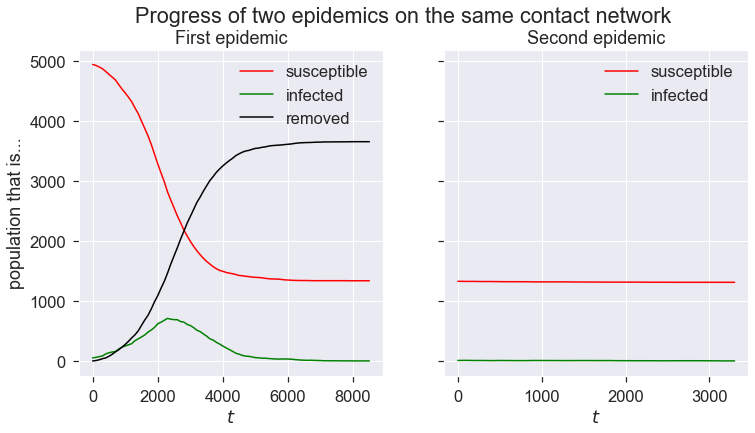

In [18]:
(fig, axs) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# plot the first epidemic
ax = axs[0]
timeseries1 = rc1[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
ts1 = timeseries1[epydemic.Monitor.OBSERVATIONS]
ss1 = timeseries1[epydemic.SIR.SUSCEPTIBLE]
is1 = timeseries1[epydemic.SIR.INFECTED]
rs1 = timeseries1[epydemic.SIR.REMOVED]
ax.plot(ts1, ss1, 'r-', label='susceptible')
ax.plot(ts1, is1, 'g-', label='infected')
ax.plot(ts1, rs1, 'k-', label='removed')
ax.set_xlabel('$t$')
ax.set_ylabel('population that is...')
ax.set_title('First epidemic')
ax.legend(loc='upper right')

# plot the second epidemic on the residual network
ax = axs[1]
timeseries2 = rc2[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
ts2 = timeseries2[epydemic.Monitor.OBSERVATIONS]
ss2 = timeseries2[epydemic.SIR.SUSCEPTIBLE]
is2 = timeseries2[epydemic.SIR.INFECTED]
ax.plot(ts2, ss2, 'r-', label='susceptible')
ax.plot(ts2, is2, 'g-', label='infected')
ax.set_xlabel('$t$')
ax.set_title('Second epidemic')
ax.legend(loc='upper right')

# fine-time the figure
plt.suptitle('Progress of two epidemics on the same contact network')
axs[0].set_ylabel('population that is...')

_ = plt.show()

The first epidemic happens as we would expect: a burst of infections followed by a dying-away. But the second epidemic looks as though nothing happens. We can check by looking at the final compartment sizes.

In [12]:
print('Remaining susceptible {s}, removed {r}'.format(s=len(m2.compartment(epydemic.SIR.SUSCEPTIBLE)), r=len(m2.compartment(epydemic.SIR.REMOVED))))

Remaining susceptible 1313, removed 26


So the same disease barely affected any nodes, despite being re-introduced.

Why is this? The first epidemic changed the topology of the network. Specifically it reduced the mean degree of nodes because so many of the nodes were removed. In doing so it reduced the disease's opportunities to spread, effectively reducing $R_0$ below the critical threshold.

In [14]:
print('Mean degree of initial network {kmean}'.format(kmean=kmean))
print('Mean degree of residual network {kmean:.2f}'.format(kmean=numpy.mean(list(dict(h.degree()).values()))))

Mean degree of initial network 20
Mean degree of residual network 5.19


We can show this graphically &ndash; if less scientifically usefully &ndash; by plotting the progress of the disease through the network.

In [ ]:
(fig,axs) = plt.subplots(1, 3, figsize=(12, 5))

# colours fgor compartments
colours = dict()
colours[epydemic.SIR.SUSCEPTIBLE] = 'red'
colours[epydemic.SIR.INFECTED] = 'green'
colours[epydemic.SIR.REMOVED] = 'black'

# plot the final network of the first epidemic, colouring for compartment
ax = axs[0]
final = m1.network()
pos1 = networkx.drawing.layout.random_layout(final)
ncs = [ colours[m1.getCompartment(n)] for n in final.nodes() ]
networkx.draw_networkx(final, pos=pos1, ax=ax, node_color=ncs, node_size=5, with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('After first epidemic')

# plot residual network for the second epidemic
ax = axs[1]
final = m2.network()
pos2 = { n: pos1[n] for n in pos1.keys() if n in final.nodes() }
networkx.draw_networkx(final, pos=pos2, ax=ax, node_color=colours[epydemic.SIR.SUSCEPTIBLE], node_size=5, with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('Residual susceptibles')

# plot the final network of the second epidemic
ax = axs[2]
ncs = [ colours[m2.getCompartment(n)] for n in final.nodes() ]
networkx.draw_networkx(final, pos=pos2, ax=ax, node_color=ncs, node_size=5, with_labels=False, edgelist=[])
ax.axis('off')
ax.set_title('After second epidemic')

# fine-tune figure
plt.suptitle('Progress of two epidemics')

# the figure we've created is large -- very large, actually -- because of the large
# network. Since we don't want to create a large notebook, we generate and  save the
# file without displaying it and then re-load the saved image
plt.savefig('herd-finals.png', dpi=300, bbox_inches='tight')
plt.close(fig)

```{raw} latex
\begin{fullwidth}
```

![Herd immunity](herd-finals.png)

```{raw} latex
\end{fullwidth}
```

In the left-hand panel we have the network after the first epidemic, with black nodes being those that have been infected. In the middle panel we remove these nodes, leaving only the residual susceptibles: we've not drawn the connections for reasons of scale. In the right-hand panel we show the network after the second epidemic &ndash; look carefully to find the nodes that were infected! The visual first impression is what's important, though: after the first epidemic the network had been mostly infected, but after the second it was largely untouched despite the fact that the same disease was introduced both times. The population has been rendered herd-immune by its first brush with the disease. 

(sec:herd-complexity)=
## The complexities of immunity

This description makes things sound simple. Infecting the population once means that they can't, as a body, be infected again, and so the risks of subsequent disease outbreaks are minimised.

Not quite. There are more things we need to consider.

Firstly, and most importantly, gaining herd immunity through infection means that a lot of people have to become sick. Depending on the disease, that can result in a lot of misery and a lot of death. We glossed-over the difference between these two factors in using SIR as our disease model, but we need to remember that "removed" (in the SIR sense)  includes those who recovered and those who died &ndash; neither of whom, in this simple model, take any further part in this or future epidemics.

While the difference between recovered and dead therefore doesn't matter mathematically, it matters a lot to the individuals concerned &ndash; or rather, it matters to those who survive. If a disease with a low death rate infects 60% of a population that still means a *lot* of deaths. 

Secondly, a further assumption of SIR is that immunity is a binary thing: one is *either* susceptible *or* removed, and if susceptible one is *entirely* susceptible and if removed one is *completely* removed. These assumptions aren't an accurate model of many diseases.

In many diseases, infection by the disease confers only **partial immunity** to further infection. Essentially this decreases an individual's own personal probability $p_{\mathit{infect}}$, making them less likely to be infected at subsequent encounters.

In other diseases. infection confers **temporary immunity** so that an individual's $p_{\mathit{infect}}$ changes with time, perhaps dropping to zero immediately after recovery and rising over time. The exact way in which immunity decays may be different too, perhaps rising steadily or perhaps jumping, and perhaps eventually reaching a "normal" level as though the first infection hadn't occurred. And of course one can always have the case of **temporary partial immunity** that combines the features of both.

To all these complexities we also need to add uncertainty. In an epidemic of a new disease we almost certainly *don't know* what, if any, immunity infection confers. This implies that we don't know whether a recurrence of the disease will result in another epidemic or not.

All this means that achieving herd immunity isn't a viable strategy for managing new diseases with large potential epidemic sizes, even if they're known (or assumed) to have relatively low mortality rates. A tiny fraction of a huge number can still be considerable. Fortunately herd immunity is not the only management strategy we have available to us. 

## Questions for discussion

- How would you work out whether a particular disease conferred full immunity, or only partial immunity?
- Is partial immunity any help in managing a disease? &ndash; it still leave speople at risk after infection